In [28]:
import scipy.io
import numpy as np
import h5py
import xarray as xr
import matplotlib as plt
import pandas as pd

In [29]:
riskmap=xr.open_dataset('Riskmaps/320ktmig5aptnearstk_destriping_0_0075_amplitude_AGF_1_netcdf.nc').load()
riskmap.close()
riskmap=riskmap.assign_coords(X=riskmap.coordX)
riskmap=riskmap.assign_coords(Y=riskmap.coordY)

In [30]:
riskmap

<xarray.Dataset>
Dimensions:               (y: 193, x: 1289)
Coordinates:
    X                     (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    Y                     (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    coordY                (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [31]:

riskmap['prob']=riskmap.location_probability+0.001*riskmap.location_probability.sum()
riskmap['prob']=riskmap.prob/riskmap.prob.sum()
riskmap

<xarray.Dataset>
Dimensions:               (y: 193, x: 1289)
Coordinates:
    X                     (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    Y                     (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
Dimensions without coordinates: y, x
Data variables:
    coordX                (y, x) float32 5.678e+05 5.678e+05 ... 5.715e+05
    coordY                (y, x) float32 5.781e+06 5.781e+06 ... 5.783e+06
    location_probability  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prob                  (y, x) float64 4.004e-06 4.004e-06 ... 4.004e-06

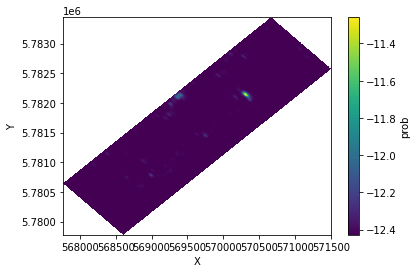

In [32]:
np.log(riskmap.prob).plot(x='X',y='Y')

In [54]:

xxq=xqq.to_dataset(name='prob').rename_dims({'dim_0':'i','dim_1':'j'})

In [74]:
mxs=xxq.prob.argmax(dim=...)
mxs

{'i': <xarray.DataArray 'prob' ()>
 array(25),
 'j': <xarray.DataArray 'prob' ()>
 array(18)}

In [85]:
xx=np.arange(xxq.dims['i'])-mxs['i'].values
yy=np.arange(xxq.dims['j'])-mxs['j'].values

In [89]:
xxq=xxq.assign_coords({'x':xx,'y':yy})

In [92]:
xxq

<xarray.Dataset>
Dimensions:  (i: 36, j: 31, x: 36, y: 31)
Coordinates:
  * x        (x) int64 -25 -24 -23 -22 -21 -20 -19 -18 -17 ... 3 4 5 6 7 8 9 10
  * y        (y) int64 -18 -17 -16 -15 -14 -13 -12 -11 ... 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, j
Data variables:
    prob     (i, j) float64 0.001886 0.006762 0.006848 ... 0.002162 0.0 0.0

In [54]:
data=xr.open_dataset('Outdata/fields_01.nc')
data

<xarray.Dataset>
Dimensions:  (time: 192, xc: 100, yc: 150)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-01T00:15:00 ... 2016-11-03
  * xc       (xc) float64 5.677e+05 5.678e+05 5.679e+05 ... 5.716e+05 5.716e+05
  * yc       (yc) float64 5.772e+06 5.772e+06 5.772e+06 ... 5.778e+06 5.778e+06
Data variables:
    C        (time, xc, yc) float64 ...
    u        (time, xc, yc) float64 ...
    v        (time, xc, yc) float64 ...
Attributes:
    max_prob:   0.00026566265
    sum_prob:   0.9211906
    risk file:  Q13_Q16_k1k2filt_10_10_destriping_0_01_amplitude_AGF_2_netcdf.nc
    treshold:   0.1
    cluster:    dbscan
    D:          0.1

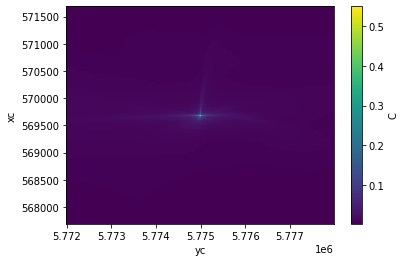

In [82]:
data.C.where(data.C.diff(dim='time').std(dim='time')>0.00005).std(dim='time').plot()

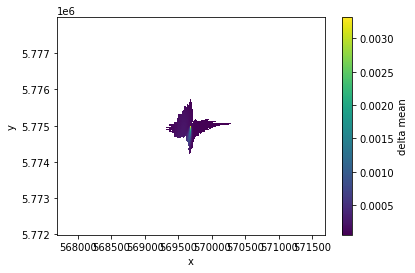

In [51]:
zoom['delta mean'].plot()

In [53]:
data.x.diff(dim='x')

<xarray.DataArray 'x' (x: 99)>
array([90.10311453, 86.49898995, 83.03903035, 79.71746914, 76.52877037,
       73.46761956, 70.52891477, 67.70775818, 64.99944786, 62.39946994,
       59.90349114, 57.5073515 , 55.20705744, 52.99877514, 50.87882413,
       48.84367117, 46.88992432, 45.01432735, 43.21375426, 41.48520409,
       39.82579592, 38.23276409, 36.70345352, 35.23531538, 33.82590277,
       32.47286666, 31.17395199, 29.92699391, 28.72991415, 27.58071759,
       26.47748888, 25.41838933, 24.40165375, 23.4255876 , 22.4885641 ,
       21.58902154, 20.72546068, 19.89644225, 19.10058456, 18.33656118,
       17.60309873, 16.89897478, 16.22301579, 15.57409516, 14.95113135,
       14.3530861 , 13.77896265, 13.22780415, 12.69869198, 12.439535  ,
       12.69869198, 13.22780415, 13.77896265, 14.3530861 , 14.95113135,
       15.57409516, 16.22301579, 16.89897478, 17.60309873, 18.33656118,
       19.10058456, 19.89644225, 20.72546068, 21.58902154, 22.4885641 ,
       23.4255876 , 24.40165375, 25.41838933, 26.47748888, 27.58071759,
       28.72991415, 29.92699391, 31.17395199, 32.47286666, 33.82590277,
       35.23531538, 36.70345352, 38.23276409, 39.82579592, 41.48520409,
       43.21375426, 45.01432735, 46.88992432, 48.84367117, 50.87882413,
       52.99877514, 55.20705744, 57.5073515 , 59.90349114, 62.39946994,
       64.99944786, 67.70775818, 70.52891477, 73.46761956, 76.52877037,
       79.71746914, 83.03903035, 86.49898995, 90.10311453])
Coordinates:
  * x        (x) float64 5.678e+05 5.679e+05 5.68e+05 ... 5.716e+05 5.716e+05